## Initial Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
from pylab import *
import pprint
import sys

from sklearn.model_selection import KFold 

## Reading Data

In [5]:
data = pd.read_csv("../input_data/AdmissionDataset/data.csv")

In [6]:
# removing last two columns as their values are in the range [0, 1]
normalized_data = data.iloc[:, :-2]

# remove "Serial No." column
normalized_data.drop(['Serial No.'], axis = 1, inplace = True)

normalized_data = (normalized_data - normalized_data.mean())/normalized_data.std()

# Append the last two columns again
normalized_data[["Research", "Chance of Admit"]] = data[["Research", "Chance of Admit"]]

In [7]:
# Splitting in 80-20 ratio
train, validate = np.split(normalized_data,[int(.8*len(normalized_data))])
train = train.reset_index(drop = True)
validate = validate.reset_index(drop = True)

# For Random Splitting
# data=data.sample(frac=1).reset_index(drop=True)
# train, validate = np.split(data, [int(.8*len(data))])

# train

In [8]:
Class = "Chance of Admit"

In [9]:
# Assign all the attributes columns as a matrix to X
X_train = train.iloc[:, :-1]

# Concatenate an array of ones to X
ones = np.ones([X_train.shape[0],1])
X_train = np.concatenate((ones, X_train),axis=1)

# Assign the last column to Y.
Y_train = np.array([train.iloc[:, -1].values]).T    # .T for transpose

In [10]:
# Assign all the attributes columns as a matrix to X
X_validate = validate.iloc[:, :-1]

# Concatenate an array of ones to X
ones = np.ones([X_validate.shape[0],1])
X_validate = np.concatenate((ones, X_validate),axis=1)

# Assign the last column to Y.
Y_validate = np.array([validate.iloc[:, -1].values]).T    # .T for transpose

In [11]:
# Learning rate
alpha = 0.01

In [12]:
def mse(X, Y, theta):
    errors = (X @ theta.T) - Y
    square_errors = np.power(errors, 2)
    return errors, square_errors, (np.sum(square_errors) / (2 * len(X)))

In [17]:
def plot(max_lambda, cost_train, cost_validate, reg_type):
    fig, ax = plt.subplots(figsize=(12,6))
    plt.title(reg_type) 
    ax.plot(range(max_lambda+1), cost_train, color="Blue", lw=1, ls='-',label = 'Training Error');
    ax.plot(range(max_lambda+1), cost_validate, color="Red", lw=1, ls='-',label = 'Validation Error');
    plt.xlabel("Lambda")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

## Part-1: LASSO Regression (L1 Regularization)
## (Least Absolute Shrinkage and Selection Operator)

In [18]:
def lasso_gradient_descent(X, Y, nIterations, alpha, lmbda):
    # Initialize theta as an array of zeros.
    theta = np.zeros([1, X.shape[1]])

    for i in range(nIterations):
        theta0 = theta[:, 0]
        theta1_n = theta[:, 1:]

        ones = np.ones([X.shape[0],1])
        theta0 = theta0 - (alpha/len(X))*(np.array([np.sum((ones * (X @ theta.T - Y)), axis = 0)]))
        theta1_n = theta1_n - (alpha/len(X))*(np.array([np.sum((X[:, 1:] * (X @ theta.T - Y)), axis = 0)]) + (lmbda * np.where(theta1_n >= 0,1,-1)))

        theta[:, 0] = theta0
        theta[:, 1:] = theta1_n
    return theta

In [19]:
cost_train = []
cost_validate = []
max_lambda = 50
for lmbda in range(max_lambda+1):
    nIterations = 700
    theta = lasso_gradient_descent(X_train, Y_train, nIterations, alpha, lmbda)

    cost_train.append(mse(X_train, Y_train, theta)[2])
    cost_validate.append(mse(X_validate, Y_validate, theta)[2])

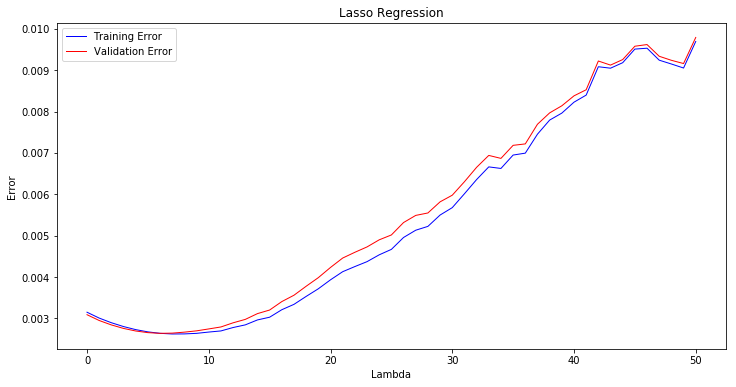

In [20]:
plot(max_lambda, cost_train, cost_validate, "Lasso Regression")

## Part-2: Ridge Regression (L2 Regularization)

In [21]:
def ridge_gradient_descent(X, Y, nIterations, alpha, lmbda):
    # Initialize theta as an array of zeros.
    theta = np.zeros([1, X.shape[1]])
    
    for i in range(nIterations):
        theta0 = theta[:, 0]
        theta1_n = theta[:, 1:]
        
        ones = np.ones([X.shape[0],1])
        theta0 = theta0 - (alpha/len(X))*(np.array([np.sum((ones * (X @ theta.T - Y)), axis = 0)]))
        theta1_n = theta1_n*(1 - lmbda*(alpha/len(X))) - (alpha/len(X))*(np.array([np.sum((X[:, 1:] * (X @ theta.T - Y)), axis = 0)]))
        
        theta[:, 0] = theta0
        theta[:, 1:] = theta1_n
    return theta

In [22]:
cost_train = []
cost_validate = []
max_lambda = 500
for lmbda in range(max_lambda+1):
    nIterations = 700
    theta = ridge_gradient_descent(X_train, Y_train, nIterations, alpha, lmbda)

    cost_train.append(mse(X_train, Y_train, theta)[2])
    cost_validate.append(mse(X_validate, Y_validate, theta)[2])

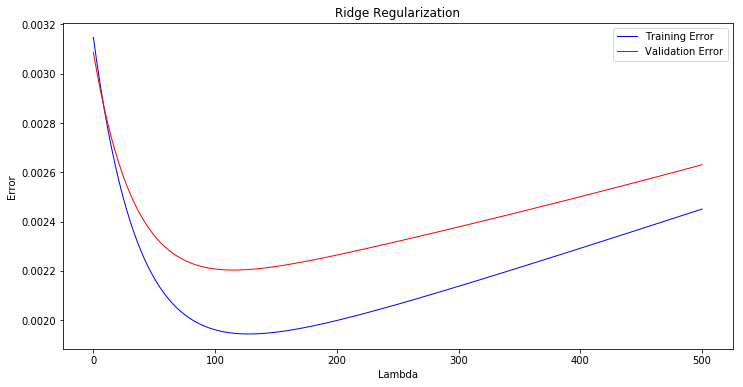

In [23]:
plot(max_lambda, cost_train, cost_validate, "Ridge Regularization")

#### Observations:
For the same lambda, LASSO has higher RSS (poorer fit) as compared to ridge regression.

## Part-3:<br>Analyse how the hyper-parameter λ plays a role in deciding between bias and variance.

**1. λ = 0:**
   * The objective becomes same as simple linear regression.
   * We’ll get the same coefficients as simple linear regression.

**2. λ = ∞:**
   * The coefficients will be zero. Because of infinite weightage on coefficients, anything less than zero will make the objective infinite.
<br>

**3. 0 < λ < ∞:**
   * The magnitude of λ will decide the weightage given to different parts of objective.
   * The coefficients will be somewhere between 0 and ones for simple linear regression.


With low values of lambda, the model remains susceptible to high variance depending on the order of the linear regressor.

As the value of lambda increases, the model complexity reduces.
Thereby, reducing the variance.
High lambda values can lead to significant underfitting.

## Part-4: <br>Analyse how the two different regularisation techniques affect regression weights in terms of their values and what are the differences between the two.

The key difference is in how they assign penalty to the coefficients:

1. **Ridge Regression:**
   * Performs L2 regularization, i.e. adds penalty equivalent to **square of the magnitude** of coefficients
   * Minimization objective = LS Obj + λ * (sum of square of coefficients)
   * It includes all (or none) of the features in the model. Thus, the major advantage of ridge regression is coefficient shrinkage and reducing model complexity.
   * It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high number of features, say in millions, as it will pose computational challenges.
   * It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

<br>

2. **Lasso Regression:**
   * Performs L1 regularization, i.e. adds penalty equivalent to **absolute value of the magnitude** of coefficients
   * Minimization objective = LS Obj + λ * (sum of absolute value of coefficients)
   * Along with shrinking coefficients, lasso performs feature selection as well. Some of the coefficients become exactly zero, which is equivalent to the particular feature being excluded from the model.
   * Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases where the #features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.
   * It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.


**‘LS Obj’** refers to **‘least squares objective** i.e. the linear regression objective without regularization.

## Part-5: k-fold cross validation

In [24]:
# Assign all the attributes columns as a matrix to kf_X
kf_X = normalized_data.iloc[:, :-1]

# Concatenate an array of ones to X
ones = np.ones([kf_X.shape[0],1])
kf_X = np.concatenate((ones, kf_X),axis=1)

# Assign the last column to kf_Y.
kf_Y = np.array([normalized_data.iloc[:, -1].values]).T    # .T for transpose

In [25]:
def k_fold_cross_validation(k, X, Y):
    nIterations = 700
    lmdba = 400
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    KFold(n_splits=k, random_state=None, shuffle=False)
    
    cost_validate = []
    for train_index, validate_index in kf.split(X):
        X_train, X_validate = X[train_index], X[validate_index]
        Y_train, Y_validate = Y[train_index], Y[validate_index]
        theta = ridge_gradient_descent(X_train, Y_train, nIterations, alpha, lmbda)
        cost_validate.append(mse(X_validate, Y_validate, theta)[2])
        
    return np.mean(cost_validate)

In [26]:
mean_square_errors = []
for k in range(3, 40):
    mean_square_errors.append(k_fold_cross_validation(k, kf_X, kf_Y))

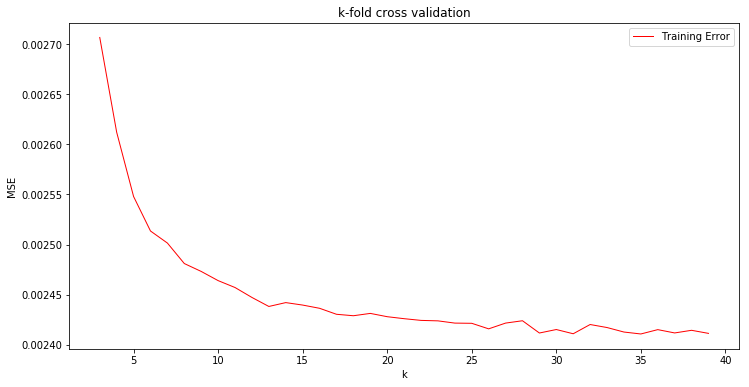

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("k-fold cross validation") 
ax.plot(range(3, 40), mean_square_errors, color="Red", lw=1, ls='-',label = 'Training Error');
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Leave-One-Out Cross Validation

In [28]:
loocv_mse = k_fold_cross_validation(len(kf_X), kf_X, kf_Y)

## LOOCV MSE

In [29]:
loocv_mse

0.002400843712555457